In [1]:
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv() 

# import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

# import boto3
# s3 = boto3.client('s3')
# s3.upload_file('path/to/your/file', 'mlflow-artifacts-evs', 'your/s3/path')


In [2]:

os.environ["AWS_PROFILE"] = "mac2aws" 
TRACKING_SERVER_HOST = os.environ["TRACKING_SERVER_HOST"]  
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [3]:

notebook_dir = os.getcwd()

file_path = os.path.join(notebook_dir, 'data', 'df_filtered.csv')
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
df_filtered = pd.read_csv(file_path)

In [4]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://ec2-3-14-112-137.us-east-2.compute.amazonaws.com:5000'


In [5]:
mlflow.search_experiments() # list_experiments API has been removed, you can use search_experiments instead().

[<Experiment: artifact_location='s3://mlflow-artifacts-evs/5', creation_time=1725572707889, experiment_id='5', last_update_time=1725572707889, lifecycle_stage='active', name='energy-prediction-pipeline_updated', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/4', creation_time=1723958095275, experiment_id='4', last_update_time=1723958095275, lifecycle_stage='active', name='energy-prediction-pipeline', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/3', creation_time=1723952998415, experiment_id='3', last_update_time=1723952998415, lifecycle_stage='active', name='my-experiment-3', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/2', creation_time=1723492994445, experiment_id='2', last_update_time=1723492994445, lifecycle_stage='active', name='my-experiment-2', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/1', creation_time=1723478188985, experiment_id='1', last_update_time=1723478188985, lifecycle_stage

In [6]:
mlflow.set_experiment("energy-prediction-pipeline_updated")

<Experiment: artifact_location='s3://mlflow-artifacts-evs/5', creation_time=1725572707889, experiment_id='5', last_update_time=1725572707889, lifecycle_stage='active', name='energy-prediction-pipeline_updated', tags={}>

In [7]:
df_filtered['created_date'] = pd.to_datetime(df_filtered['created_date'])
df_filtered['day_of_week'] = df_filtered['created_date'].dt.dayofweek
df_filtered['month'] = df_filtered['created_date'].dt.month
df_filtered['day'] = df_filtered['created_date'].dt.day
df_filtered['year'] = df_filtered['created_date'].dt.year
df_filtered['Sta_Loc'] = df_filtered['stationId'].astype(str) + '_' + df_filtered['locationId'].astype(str)



In [8]:
features = ['day_of_week', 'created_date', 'chargeTimeHrs', 'distance','stationId', 'locationId']

X = df_filtered[features]
# X = df_filtered.drop(columns=['kwhTotal'])

y = df_filtered['kwhTotal']

In [9]:
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert Timestamps to strings
df_train['created_date'] = df_train['created_date'].astype(str)
df_test['created_date'] = df_test['created_date'].astype(str)

# Save training and test datasets to CSV files
train_df = pd.DataFrame(df_train, columns=df_train.columns)
train_df['kwhTotal'] = y_train
train_df.to_csv("./data/train.csv", index=False)

test_df = pd.DataFrame(df_test, columns=df_test.columns)
test_df['kwhTotal'] = y_test
test_df.to_csv("./data/test.csv", index=False)

# Convert DataFrame rows to dictionaries
df_train_dicts = df_train.to_dict(orient='records')
df_test_dicts = df_test.to_dict(orient='records')

# dv = DictVectorizer()

# # Fit and transform the training data
# X_train = dv.fit_transform(df_train_dicts)

# # Transform the test data
# X_test = dv.transform(df_test_dicts)



In [10]:

# Start the MLflow run
with mlflow.start_run() as run:
    mlflow.log_param("model_type", "RandomForest")

    # Log the model parameters
    params = dict(max_depth=20, n_estimators=150, min_samples_leaf=10, random_state=42)
    mlflow.log_params(params)
    
    pipeline = make_pipeline(
        DictVectorizer(),
        RandomForestRegressor(**params, n_jobs=-1)
    )

    pipeline.fit(df_train_dicts, y_train)
    y_pred = pipeline.predict(df_test_dicts)

    # Calculate and log metrics
    rmse = mean_squared_error(y_pred, y_test, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(params, rmse, r2)

    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric("r2", r2)
    
    # Log the training and test datasets
    mlflow.log_artifact("./data/train.csv", artifact_path="datasets/training")
    mlflow.log_artifact("./data/test.csv", artifact_path="datasets/testing")
    # Log the model
    mlflow.sklearn.log_model(pipeline, artifact_path="models")

    # with open ('./models/xgboost_energy_model_dv.bin', 'wb') as f_out:
    #     pickle.dump((dv, model), f_out)
    # mlflow.log_artifact('xgboost_energy_model_dv.bin')



/Users/amberm/.local/share/virtualenvs/project-O1Wr8Khj/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'max_depth': 20, 'n_estimators': 150, 'min_samples_leaf': 10, 'random_state': 42} 1.3121425774455544 0.681228112732849


2024/09/05 17:47:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/05 17:47:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run caring-wasp-487 at: http://ec2-3-14-112-137.us-east-2.compute.amazonaws.com:5000/#/experiments/5/runs/9c137f1ba2434e1a9d3c07bb9b0a0dc4.
2024/09/05 17:47:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-3-14-112-137.us-east-2.compute.amazonaws.com:5000/#/experiments/5.


In [11]:
mlflow.search_experiments()


[<Experiment: artifact_location='s3://mlflow-artifacts-evs/5', creation_time=1725572707889, experiment_id='5', last_update_time=1725572707889, lifecycle_stage='active', name='energy-prediction-pipeline_updated', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/4', creation_time=1723958095275, experiment_id='4', last_update_time=1723958095275, lifecycle_stage='active', name='energy-prediction-pipeline', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/3', creation_time=1723952998415, experiment_id='3', last_update_time=1723952998415, lifecycle_stage='active', name='my-experiment-3', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/2', creation_time=1723492994445, experiment_id='2', last_update_time=1723492994445, lifecycle_stage='active', name='my-experiment-2', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-evs/1', creation_time=1723478188985, experiment_id='1', last_update_time=1723478188985, lifecycle_stage

## Interacting with the model registry


In [12]:
from mlflow.tracking import MlflowClient


# Initialize MLflow client
client = MlflowClient(f"http://{TRACKING_SERVER_HOST}:5000")

In [13]:
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1723799381714, description='', last_updated_timestamp=1723799381714, latest_versions=[], name='2kjaF0EfT4lHTkS4fGTgPoCs8ZF', tags={}>,
 <RegisteredModel: aliases={}, creation_timestamp=1724724060792, description='', last_updated_timestamp=1724724060997, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1724724060997, current_stage='None', description='', last_updated_timestamp=1724724060997, name='energy-consumption-prediction-pipeline', run_id='ccb1e1f2811a426396410a62e6c81da5', run_link='', source='s3://mlflow-artifacts-evs/4/ccb1e1f2811a426396410a62e6c81da5/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='1'>], name='energy-consumption-prediction-pipeline', tags={}>,
 <RegisteredModel: aliases={}, creation_timestamp=1723500706238, description='', last_updated_timestamp=1724265006216, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1724265006216, current_stage='None', desc

### Regester an empty model with no version associated

In [14]:
registered_name = 'Energy forecast'
model_uri = f"runs:/{run.info.run_id}/models"

# Register an empty registered model with no version associated
try:
    result = mlflow.register_model(
        model_uri=model_uri,
        name=registered_name
    )
    print(f"Model registered with version: {result.version}")
except Exception as e:
    print(f"An error occurred: {e}")
print(f"Name: {result.name}")
print(f"Version: {result.version}")

Registered model 'Energy forecast' already exists. Creating a new version of this model...
2024/09/05 17:47:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Energy forecast, version 18


Model registered with version: 18
Name: Energy forecast
Version: 18


Created version '18' of model 'Energy forecast'.


### Regester a new version of the model (when incremental development)
With the version information, such as `tags` and `description`.

In [15]:

# # Define model details
# name = 'Energy usage forecast'
# model_uri = f"runs:/{run.info.run_id}/models"

# tags = {"Energy_Forecast": "Randomforest"}
# desc = "This is the forecasting model to predict the energy usage."

# from mlflow.store.artifact.runs_artifact_repo import RunsArtifactRepository

# try:
#     # Register model name in the model registry
#     client.create_registered_model(name)

#     # Create a new version of the model under the registered model name
#     model_src = RunsArtifactRepository.get_underlying_uri(model_uri)
#     client.create_model_version(name = name, source = model_src, run_id = run.info.run_id, tags=tags, description = desc)

#     print(f"New registered model '{name}' created.")
# except mlflow.exceptions.MlflowException as e:
#     if "RESOURCE_ALREADY_EXISTS" in str(e):
#          print(f"Model '{name}' already exists")




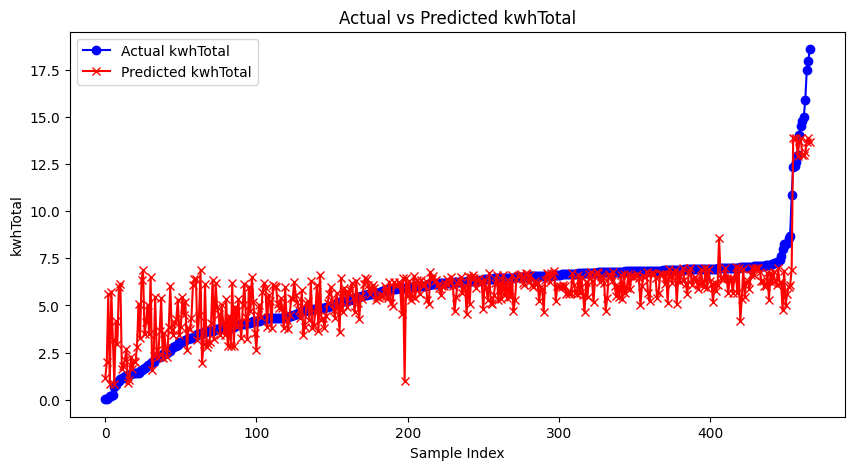

In [16]:
# Sort the actual and predicted values for better line plotting
sorted_indices = np.argsort(y_test.values)
sorted_y_test = y_test.values[sorted_indices]
sorted_y_pred = y_pred[sorted_indices]

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(sorted_y_test, label='Actual kwhTotal', color='blue', linestyle='-', marker='o')

# Plot predicted values
plt.plot(sorted_y_pred, label='Predicted kwhTotal', color='red', linestyle='-', marker='x')

plt.xlabel('Sample Index')
plt.ylabel('kwhTotal')
plt.title('Actual vs Predicted kwhTotal')
plt.legend()
plt.show()

In [17]:

# importances = model.feature_importances_
# features = dv.get_feature_names_out()

# plt.figure(figsize=(10, 5))
# sns.barplot(x=features , y=importances)
# plt.title('Feature Importances')
# plt.show()